In [1]:
import sugar_analysis as sa
import sncosmo  
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt

# Load SUGAR

In [2]:
sa.register_SUGAR(modeldir= '../../sugar_model/')

# Load new filter and new magnitude system

## Load filter

In [3]:
def new_filter(wavel, trans, band_name):
    """
    Register new filter in sncosmo.
    wavel : array 
            wavelength in A
    trans : array
            transmission
    band_name : str
                name of this filter in sncosmo
    """
    band = sncosmo.Bandpass(wavel, trans, wave_unit=u.AA, name=band_name)    
    sncosmo.registry.register(band, force=True)

## Load Magnitude system 

In [4]:
def new_mag_sys(name, path_ref_spectrum, set_band_name):
        """
        Register in sncosmo new magnitude based on a set of filters and a reference spectrum
        name : str
               name register in sncosmo for ths magnitude system
        path_ref_spectrum : str
                            path to reference spectrum, file need to be a .dat or .ascii 
                            with first colum wavelenght and flux density on second colum
        set_band_name : list of band name
                        All this name have to be register in sncosmo
        """
        def load_spectral_magsys(relpath, name=None, version=None):
            """
            load reference spectrum in sncosmo
            """
            data = np.genfromtxt(relpath)
            dispersion = data[:,0]
            flux_density = data[:,1]
            refspectrum = sncosmo.spectrum.Spectrum(dispersion, flux_density,
                                   unit=(u.erg / u.s / u.cm**2 / u.AA), wave_unit=u.AA)
            return sncosmo.magsystems.SpectralMagSystem(refspectrum, name=name)
        
        sncosmo.registry.register_loader(sncosmo.MagSystem, 'spec_ref', load_spectral_magsys,
                                 args=[path_ref_spectrum], force=True)
        set_band = {}
        
        for b in set_band_name:
            set_band[b] = ('spec_ref', 0)  #shift between the magnitude system using 'spec ref' as reference 
                                       #and the final magnitude system 0 by default
        sncosmo.registry.register(sncosmo.CompositeMagSystem(bands=set_band), name, force=True)
            
        

## Exemple

### Load filters

In [5]:
wavel_B = np.arange(4102,5100,1.)
wavel_V = np.arange(5200,6290,1.)
wavel_R = np.arange(6289,7607,1.)
trans_B = np.ones_like(wavel_B)
trans_V = np.ones_like(wavel_V)
trans_R = np.ones_like(wavel_R)
trans_B[0] = 0.0
trans_B[len(trans_B)-1] = 0.0
trans_V[0] = 0.0
trans_V[len(trans_V)-1] = 0.0
trans_R[0] = 0.0
trans_R[len(trans_R)-1] = 0.0
new_filter(wavel_B, trans_B, 'band_B')
new_filter(wavel_V, trans_V, 'band_V')
new_filter(wavel_R, trans_R, 'band_R')

### Load mag sys

In [6]:
set_band_name = ['band_B','band_V','band_R']
new_mag_sys('mag_sys', '../../sugar_analysis_data/data/MagSys/bd_17d4708_stisnic_002.ascii', set_band_name)

# Define SUGAR or SALT2 model for a given set of parameter

## Set SALT2 and SUGAR parameters 

In [69]:
#array like np.array([zhl, t0, x0, x1, c, mwebv]) or np.array([zhl, t0, Xgr, q1, q2, q3, A, mwebv])

# SALT2 
param_salt2 = np.array([0., 0., 0.004, 0., 0., 0.])

#SUGAR
param_sugar = np.array([0., 0., 5.5e-15, 0., 0., 0., 0., 0.])

## Register SALT2 model

In [70]:
salt2_source = sncosmo.get_source('salt2', version='2.4')
dust = sncosmo.CCM89Dust()
salt2_model = sncosmo.Model(source=salt2_source, 
                              effects=[dust], 
                              effect_names=['mw'], 
                              effect_frames=['obs'])   
salt2_model.set(z=param_salt2[0], t0=param_salt2[1], x0=param_salt2[2], x1=param_salt2[3], 
                c=param_salt2[4], mwebv=param_salt2[5])

## Register SUGAR model 

In [71]:
sugar_source = sncosmo.get_source('sugar')
dust = sncosmo.CCM89Dust()
sugar_model = sncosmo.Model(source=sugar_source, 
                              effects=[dust], 
                              effect_names=['mw'], 
                              effect_frames=['obs'])   
sugar_model.set(z=param_sugar[0], t0=param_sugar[1], Xgr=param_sugar[2],
                q1=param_sugar[3], q2=param_sugar[4],
                q3=param_sugar[5], A=param_sugar[6],
                mwebv=param_sugar[7])

# Compute SUGAR or SALT2 light curve in a given band

## get band from sncosmo 

In [72]:
band_B = sncosmo.get_bandpass('band_B') #one of the name bands define previously

## Compute SUGAR or SALT2 band flux for different phase

In [73]:
time = np.arange(-10, 48, 1.)

#in flux
band_flux_sugar = sugar_model.bandflux(band_B, time)
band_flux_salt2 = salt2_model.bandflux(band_B, time)
print band_flux_sugar

#in mag
band_mag_sugar = sugar_model.bandmag(band_B, 'mag_sys', time) #magsys name
band_mag_salt2 = salt2_model.bandmag(band_B, 'mag_sys',time)

[0.13760536 0.15948081 0.17978249 0.19987449 0.21900806 0.23633545
 0.25134249 0.26384196 0.27333295 0.27950453 0.28270374 0.2836602
 0.28154228 0.27458968 0.26132862 0.24444438 0.22803757 0.21329616
 0.19902495 0.18504939 0.17139319 0.15821995 0.14556329 0.13339155
 0.12184346 0.11108926 0.10097482 0.09157959 0.0832157  0.0757847
 0.06912516 0.06330567 0.05821481 0.05373911 0.04989264 0.04674048
 0.04403353 0.04137869 0.03855867 0.03584048 0.03354624 0.03178038
 0.0303174  0.02895004 0.02759075 0.02632027 0.02520028 0.02424748
 0.02341617 0.02267006 0.02199964 0.02140275 0.02085953 0.02036629
 0.01992089 0.01948615 0.01912473 0.01877161]


## Plot light curves

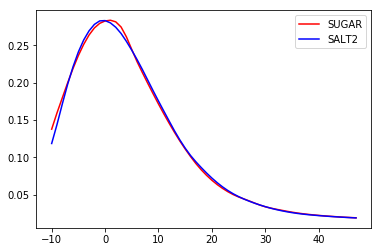

In [74]:
plt.plot(time, band_flux_sugar, label='SUGAR', c='r')
plt.plot(time, band_flux_salt2, label='SALT2', c='b')
plt.legend()
plt.show()

# Compute SUGAR or SALT2 spectra at a given time

In [75]:
time = 0.
wavel = np.arange(3255,8649, 1.)

#in flux
band_flux_sugar = sugar_model.flux(time, wavel)
band_flux_salt2 = salt2_model.flux(time, wavel)

#in AB mag
band_mag_sugar =  -2.5*np.log10(band_flux_sugar*(wavel ** 2 / 299792458. * 1.e-10))
band_mag_salt2 = -2.5*np.log10(band_flux_salt2*(wavel ** 2 / 299792458. * 1.e-10))

## Plot spectra

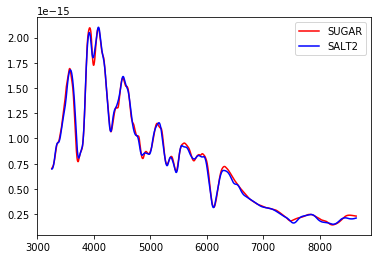

In [76]:
plt.plot(wavel, band_flux_sugar, label='SUGAR', c='r')
plt.plot(wavel, band_flux_salt2, label='SALT2', c='b')
plt.legend()
plt.show()